In [14]:
# Manejo de archivos
import os
from pathlib import Path

# Manejo de datos
import pandas as pd
import numpy as np

# Visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

#datetime
from datetime import datetime, timedelta

#outliers 
from pyod.models.mcd import MCD


In [3]:
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

# Datos crudos

In [4]:
raw_folder = Path.cwd().parent / 'data' / 'raw'

In [7]:
df_raw = pd.read_parquet(raw_folder / "df_model.parquet")

In [28]:
df.head()

,velocidad,potencia,per_solidos,celda_carga,rendimiento,flujo_agua,ruido,p80,in14,in12,...,in1,f80,dureza,wi,spi,imp_criticos,imp_estandares,jb,presion_avg,presion_ewm
date,,,,,,,,,,,,,,,,,,,,,
2022-11-15 00:00:00,75.761031,38829.984689,73.39844,78.362584,65.777186,73.931659,15.788181,64.260113,99.98547,99.93459,...,29.857760,39.063374,66.040209,94.815049,54.50695,5.75307,64.40281,0.045367,91.875140,88.832868
2022-11-15 00:00:10,75.761031,38801.377137,72.96875,78.673050,65.561138,74.949818,15.428343,64.260113,99.99471,99.97040,...,30.130893,39.063374,66.040209,94.815049,54.50695,5.75307,64.40281,0.043414,92.364275,89.271139
2022-11-15 00:00:20,75.761031,38168.832363,72.57031,78.973500,64.127962,75.815971,15.428343,64.260113,99.99471,99.97040,...,30.130893,39.063374,66.040209,94.815049,54.50695,5.75307,64.40281,0.041364,93.021432,89.849212
2022-11-15 00:00:30,75.761031,39007.987239,72.55859,78.973500,63.999458,75.815971,14.517244,64.260113,99.99471,99.97040,...,30.130893,35.656382,66.040209,94.815049,54.50695,5.75307,64.40281,0.039330,92.073034,89.613041
2022-11-15 00:00:40,75.684350,38731.447564,72.55859,79.223876,66.060989,75.815971,14.517244,64.260113,99.99544,99.97289,...,28.725894,35.479188,66.040209,94.815049,54.50695,5.75307,64.40281,0.037073,92.166380,89.520688


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 221771 entries, 2022-11-15 00:00:00 to 2022-12-15 00:00:00
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   velocidad       221771 non-null  float64
 1   potencia        221771 non-null  float64
 2   per_solidos     221771 non-null  float64
 3   celda_carga     221771 non-null  float64
 4   rendimiento     221771 non-null  float64
 5   flujo_agua      221771 non-null  float64
 6   ruido           221771 non-null  float64
 7   p80             221771 non-null  float64
 8   in14            221771 non-null  float64
 9   in12            221771 non-null  float64
 10  in10            221771 non-null  float64
 11  in8             221771 non-null  float64
 12  in6             221771 non-null  float64
 13  in4             221771 non-null  float64
 14  in3             221771 non-null  float64
 15  in2_5           221771 non-null  float64
 16  in2             221771

In [30]:
df.shape

(221771, 28)

Tenemos 27 variables, la variable objetivo será la `presion_ewm`, esta resulta de tomar el promedio de las variables pad1, pad2, ..., pad8 y aplicar un ewm.

Todos los campos son de tipo **float** y **no** tenemos datos faltantes.

## Relación presion_ewm con celda de carga

In [32]:
df[['presion_ewm', 'celda_carga']].corr()

,presion_ewm,celda_carga
presion_ewm,1.000000,0.872951
celda_carga,0.872951,1.000000


La celda de carga y la presión son dos variables que muestran una correlación alta y en la práctica proporcionan información similar sobre el peso del molino en un momento dado. Ambas variables son indicadores importantes para comprender la carga del molino durante su operación.

Sin embargo, observamos que la celda de carga a veces muestra cambios irreales durante la operación del molino. Estos cambios pueden ser especialmente notables durante los procesos de vaciado, donde la celda de carga puede disminuir hasta mil toneladas respecto a su valor anterior. Esta variabilidad puede generar incertidumbre y dificultar la interpretación precisa de la carga del molino. En realidad, se espera que la carga del molino durante estos procesos caiga aproximadamente entre 200 y 350 toneladas en casos de alta carga. Esto hace que la celda de carga pierda su interpretabilidad de toneladas y se use simplemente como indicador en tendencia, al igual que la presión.

Adicionalmente, la celda de carga tiende a descalibrarse, lo cual hace dificil comparar datos lejanos en tiempo.

Por otro lado, la presión tiende a mostrar un comportamiento más estable y predecible durante la operación del molino, lo que la convierte en un indicador más confiable de la carga del molino en comparación con la celda de carga. Por lo tanto preferimos utilizar la presión como una medida principal de la carga del molino debido a su consistencia y fiabilidad.

Text(0.5, 1.0, 'Relación presión - celda de carga')

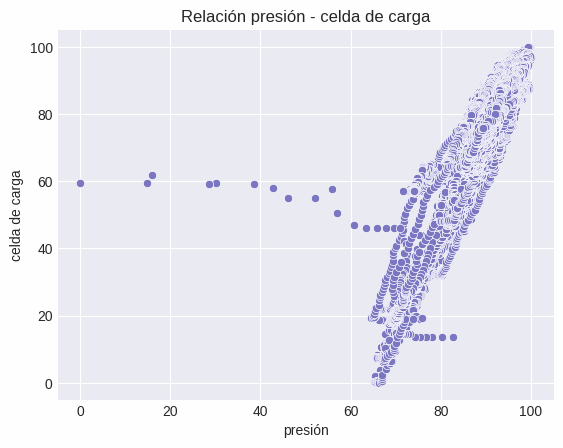

In [34]:
ax = plt.gca()
sns.scatterplot(x = 'presion_ewm',
                y = 'celda_carga',
               data = df)
ax.set_xlabel('presión')
ax.set_ylabel('celda de carga')
ax.set_title('Relación presión - celda de carga')

## Distribución de variables de interes

In [36]:
df.columns

Index(['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento',
       'flujo_agua', 'ruido', 'p80', 'in14', 'in12', 'in10', 'in8', 'in6',
       'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza', 'wi',
       'spi', 'imp_criticos', 'imp_estandares', 'jb', 'presion_avg',
       'presion_ewm'],
      dtype='object')

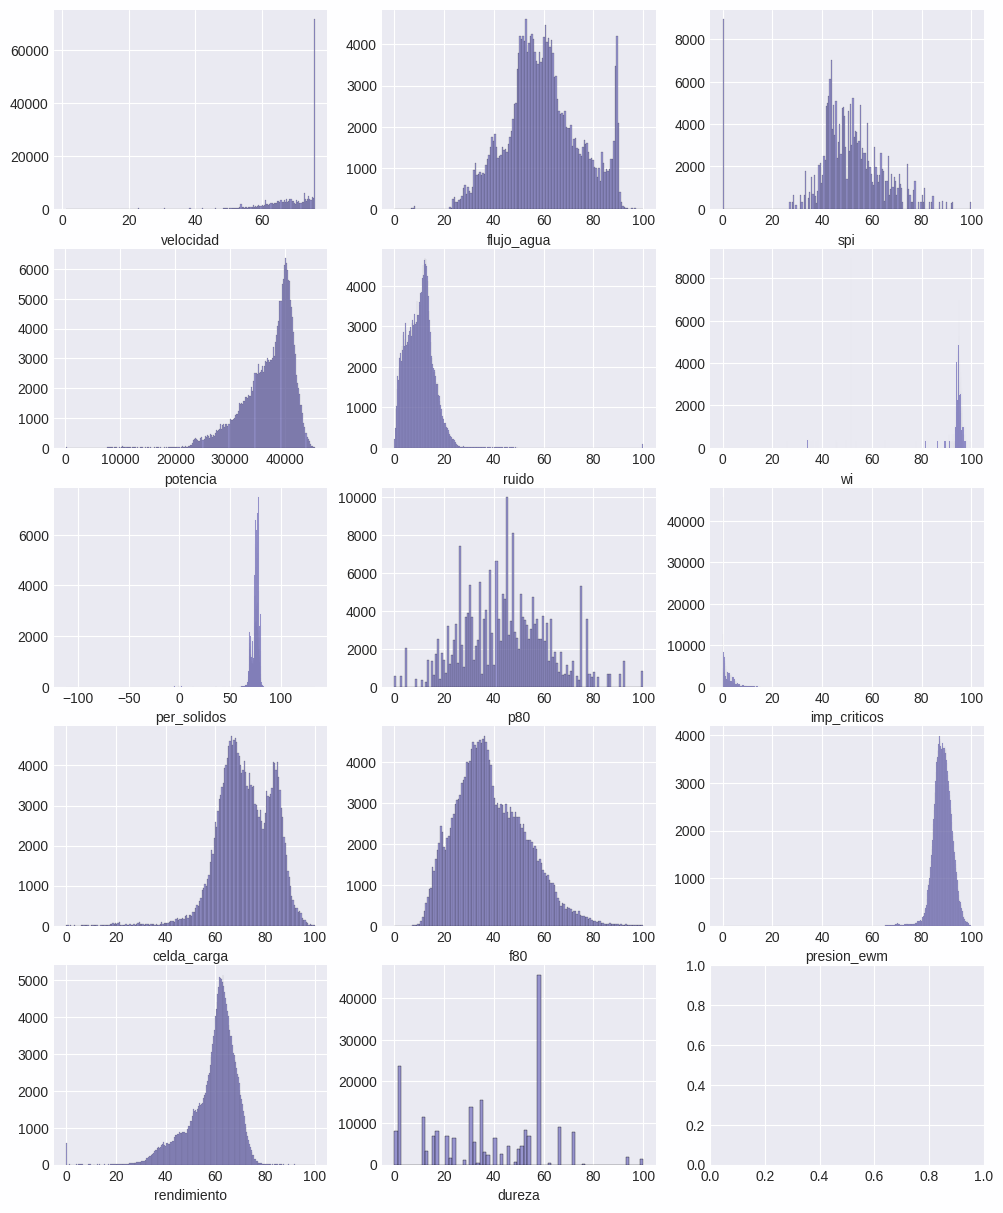

In [45]:
vars_int1 = ['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento'] 
vars_int2 = ['flujo_agua', 'ruido', 'p80', 'f80', 'dureza']
vars_int3 = ['spi', 'wi', 'imp_criticos', 'presion_ewm']

fig, axs = plt.subplots(len(vars_int1), 3, figsize = (12, 15))


for var, ax in zip(vars_int1, axs[:,0]):
    sns.histplot(df[var],
                 ax = ax)
    ax.set_ylabel('')

for var, ax in zip(vars_int2, axs[:,1]):
    sns.histplot(df[var],
                 ax = ax)
    ax.set_ylabel('')


for var, ax in zip(vars_int3, axs[:,2]):
    sns.histplot(df[var],
                 ax = ax)
    ax.set_ylabel('')




## Relacion presión potencia

In [8]:
#mantener velocidad fija
velocidad_p60 = df_raw['velocidad'].quantile(0.6)
velocidad_max = df_raw.velocidad.max()
print(f"percentil 60 de velocidad {velocidad_p60:.2f}")
print(f"velocidad máxima {velocidad_max:.2f}")

percentil 60 de velocidad 74.23
velocidad máxima 75.91


In [10]:
df_vel_fixed = df_raw[df_raw.velocidad >74.22].copy() #40% de los datos
df_vel_fixed.shape

(88751, 28)

Text(0.5, 1.0, 'celda de carga')

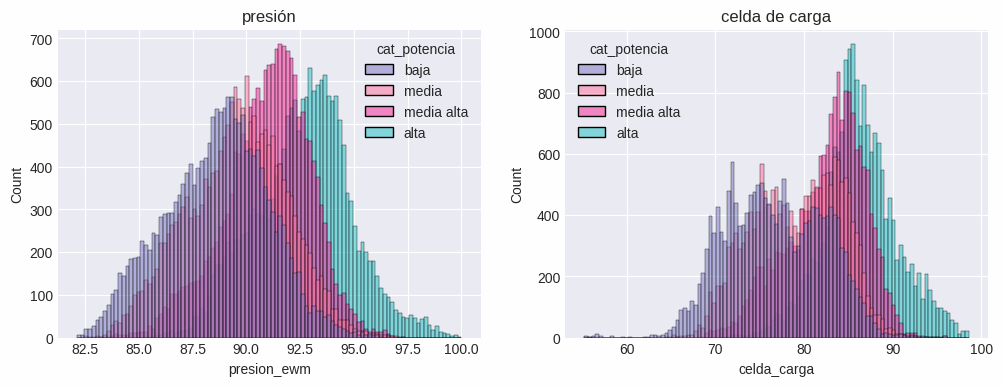

In [11]:
#a mayor carga, mayor consumo de potencia
#u
bins_p = np.quantile(df_vel_fixed.potencia, [0.2, 0.4, 0.6, 0.8, 1])
df_vel_fixed['cat_potencia'] = pd.cut(df_vel_fixed.potencia, 
                                      bins = bins_p,
                                     labels = ['baja', 'media', 'media alta', 'alta'])

fig, axs = plt.subplots(1, 2, figsize = (12, 4))
sns.histplot(x = 'presion_ewm',
            hue = 'cat_potencia',
            data = df_vel_fixed,
            ax = axs[0])
axs[0].set_title('presión')

sns.histplot(x = 'celda_carga',
            hue = 'cat_potencia',
            data = df_vel_fixed,
            ax = axs[1])
axs[1].set_title('celda de carga')

A mayor potencía se observa que la presión incrementa, lo cual es de esperar dado que el moilino tiene en su interior mayor material que debe de mover.

Este mismo efecto no se ve en la celda de carga, se observa que en potencias bajas tiene una varianza mayor, haciendo notar la descalibración de la misma y la falta de confiabilidad en esta variable como indicador de la masa interna del molino.

## Outliers

<Axes: xlabel='presion_ewm', ylabel='celda_carga'>

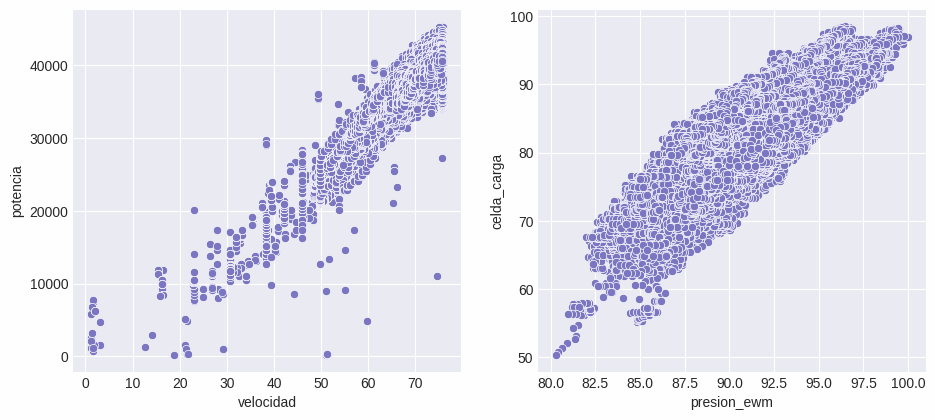

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (11, 4.7))
sns.scatterplot(x = 'velocidad',
              y = 'potencia',
             data = df_raw,
               ax = axs[0])

sns.scatterplot(x = 'presion_ewm',
              y = 'celda_carga',
             data = df_vel_fixed,
               ax = axs[1])

In [26]:
df_raw.columns

Index(['velocidad', 'potencia', 'per_solidos', 'celda_carga', 'rendimiento',
       'flujo_agua', 'ruido', 'p80', 'in14', 'in12', 'in10', 'in8', 'in6',
       'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza', 'wi',
       'spi', 'imp_criticos', 'imp_estandares', 'jb', 'presion_avg',
       'presion_ewm'],
      dtype='object')

In [27]:
mcd_model = MCD(contamination  = 0.05)
vars_outliers = ['velocidad',
                'potencia',
                'flujo_agua',
                'rendimiento',
                'presion_ewm']
mcd_model.fit(df_raw[vars_outliers])
df_raw['outlier'] = mcd_model.labels_
df_vel_fixed['outlier'] = df_raw['outlier'] #funciona por ser indice datetime

MCD(assume_centered=False, contamination=0.05, random_state=None,
  store_precision=True, support_fraction=None)

<Axes: xlabel='presion_ewm', ylabel='potencia'>

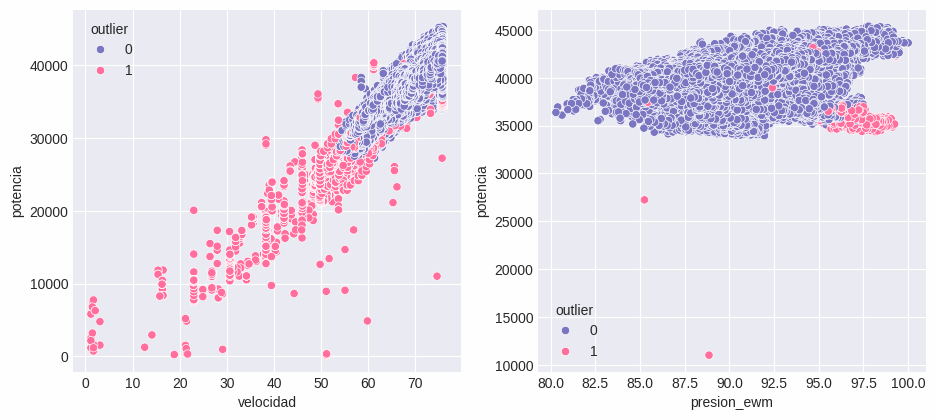

In [35]:
fig, axs = plt.subplots(1, 2, figsize = (11, 4.7))
sns.scatterplot(x = 'velocidad',
              y = 'potencia',
                hue = 'outlier',
             data = df_raw,
               ax = axs[0])

sns.scatterplot(x = 'presion_ewm',
              y = 'potencia',
             hue = 'outlier',
             data = df_vel_fixed,
               ax = axs[1])

In [ ]:
Al usar

In [42]:
df_raw.groupby('outlier')['per_solidos'].agg(['min', 'median', 'mean', 'max'])

,min,median,mean,max
outlier,,,,
0,20.87549,75.65430,75.029305,83.84766
1,-111.73050,76.47656,72.006516,133.49610


## EDA

<Axes: xlabel='date', ylabel='ruido'>

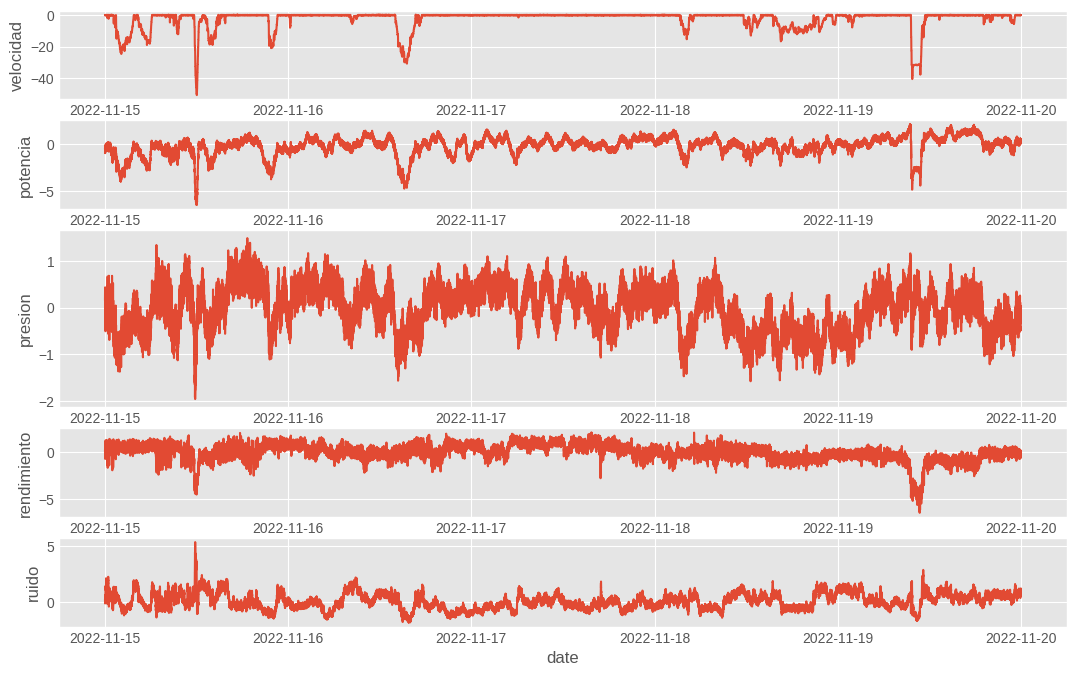

In [86]:
fig, axs = plt.subplots(5, 1, figsize = (13, 8), gridspec_kw = {'height_ratios': [1, 1, 2, 1, 1]})


sns.lineplot(x = 'date',
               y = 'velocidad',
               data = df.reset_index(),
               ax = axs[0])

sns.lineplot(x = 'date',
               y = 'potencia',
               data = df.reset_index(),
               ax = axs[1])

sns.lineplot(x = 'date',
               y = 'presion',
               data = df.reset_index(),
               ax = axs[2])

sns.lineplot(x = 'date',
               y = 'rendimiento',
               data = df.reset_index(),
               ax = axs[3])

sns.lineplot(x = 'date',
               y = 'ruido',
               data = df.reset_index(),
               ax = axs[4])



la velocidad se mantuvo bastante constante durante el tiempo de operación.

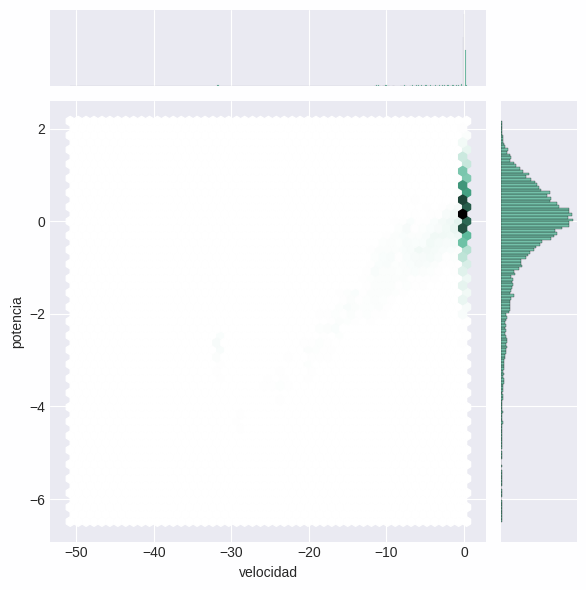

In [34]:
# plt.hexbin(df.velocidad, df.potencia, gridsize=30, cmap='inferno')
sns.jointplot(x='velocidad', y='potencia', kind="hex", color="#4CB391", data = df)


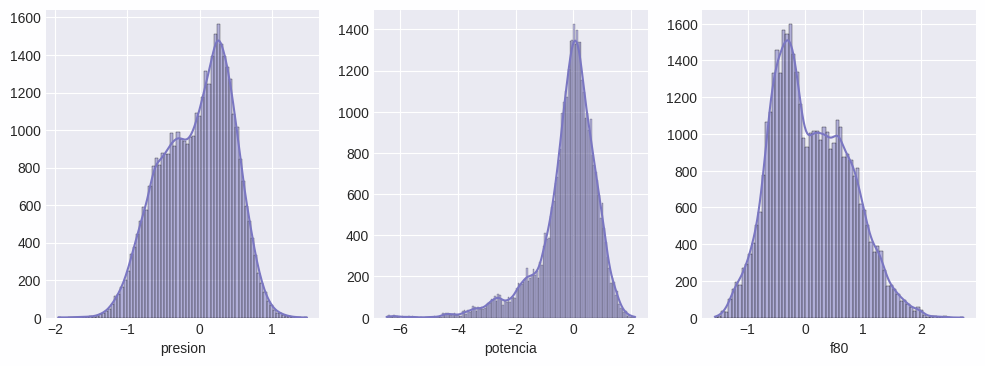

In [56]:
fig, axs = plt.subplots(1, 
                        3,
                        figsize = (12, 4))

sns.histplot(df.presion,
             ax = axs[0],
             kde = True)
sns.histplot(df.potencia,
             ax = axs[1],
             kde = True)
sns.histplot(df.f80,
             ax = axs[2],
             kde = True)

for ax in axs:
    ax.set_ylabel('')

In [66]:
bins_p = df.potencia.quantile([0.2, 0.4,0.6, 0.8, 1]).values
df['cat_potencia'] = pd.cut(df.potencia,
                            bins = bins_p,
                            labels = ['baja', 'media', 'media alta','alta'])

In [68]:
df.describe()

,velocidad,potencia,celda_carga,pad_1,pad_2,pad_3,pad_4,pad_5,pad_6,pad_7,...,in1,f80,dureza,per_solidos,wi,spi,imp_criticos,imp_estandares,jb,presion
count,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,...,39586.000000,3.958600e+04,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000,39586.000000
mean,-2.641273,-0.177962,-0.148531,0.016362,-0.019280,0.008693,-0.002362,-0.099917,-0.026502,-0.110781,...,-0.012909,8.889255e-02,0.047403,-0.092907,-1.206076,-0.014318,0.149059,-0.112919,0.037369,-0.031945
std,6.240341,1.028112,0.622128,0.662560,0.654050,0.666522,0.635048,0.682951,0.699058,0.680216,...,0.712906,6.628216e-01,0.740109,0.564308,9.163868,0.920594,0.837313,0.776966,0.678315,0.483455
min,-50.782181,-6.484589,-2.996126,-2.292517,-1.944444,-2.149351,-1.677419,-2.962963,-2.484536,-3.368852,...,-3.210599,-1.567903e+00,-1.056575,-1.842223,-71.123548,-4.947649,-1.211538,-3.217573,-1.550769,-1.953669
25%,-1.000000,-0.542808,-0.626697,-0.476190,-0.522222,-0.480519,-0.505376,-0.601852,-0.515464,-0.598361,...,-0.549290,-4.198125e-01,-0.433487,-0.590694,-0.545249,-0.506949,-0.442308,-0.535565,-0.468965,-0.398925
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-2.919452e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032961
75%,0.000000,0.457192,0.373303,0.523810,0.477778,0.519481,0.494624,0.398148,0.484536,0.401639,...,0.450710,5.801875e-01,0.566513,0.409306,0.454751,0.493051,0.557692,0.464435,0.531035,0.339543
max,0.333322,2.160959,1.183942,1.863946,1.961111,1.824675,1.854839,1.935185,2.164948,1.860656,...,2.374983,2.731476e+00,1.107937,1.555706,1.997031,2.010629,9.653846,2.221757,1.638403,1.483654


In [72]:
plt.style.use('ggplot')

<Axes: xlabel='celda_carga', ylabel='Count'>

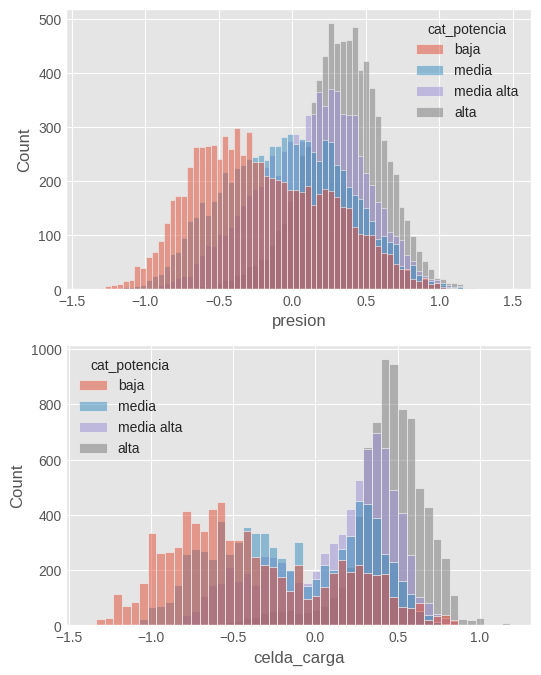

In [83]:
fig, axs = plt.subplots(2, 1, figsize = (6, 8))

sns.histplot(x = 'presion',
             hue = 'cat_potencia',
             data = df,
             ax = axs[0])

sns.histplot(x = 'celda_carga',
             hue = 'cat_potencia',
             data = df,
             ax= axs[1])

In [93]:
df.columns

Index(['velocidad', 'potencia', 'celda_carga', 'pad_1', 'pad_2', 'pad_3',
       'pad_4', 'pad_5', 'pad_6', 'pad_7', 'pad_8', 'rendimiento',
       'flujo_agua', 'ruido', 'giro', 'p80', 'in14', 'in12', 'in10', 'in8',
       'in6', 'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza',
       'per_solidos', 'wi', 'spi', 'imp_criticos', 'imp_estandares', 'jb',
       'presion', 'cat_potencia'],
      dtype='object')

<Axes: >

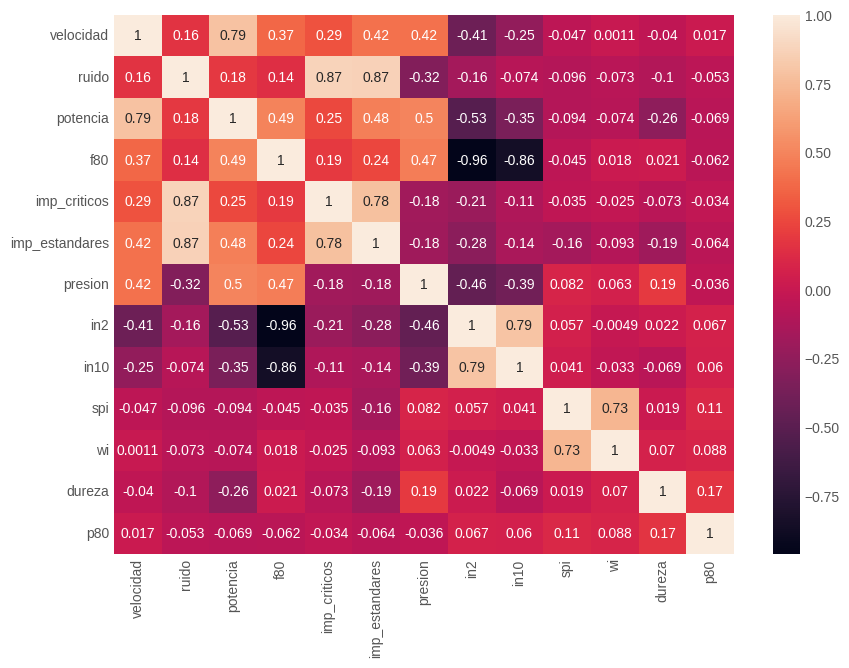

In [118]:
fig, ax = plt.subplots(figsize = (10, 7))

vars_interes = ['velocidad', 'ruido', 'potencia', 'f80', 'imp_criticos', 'imp_estandares', 'presion','in2', 'in10', 'spi', 'wi', 'dureza', 'p80']
sns.heatmap(df[vars_interes].corr(),
            annot = True)

<Axes: >

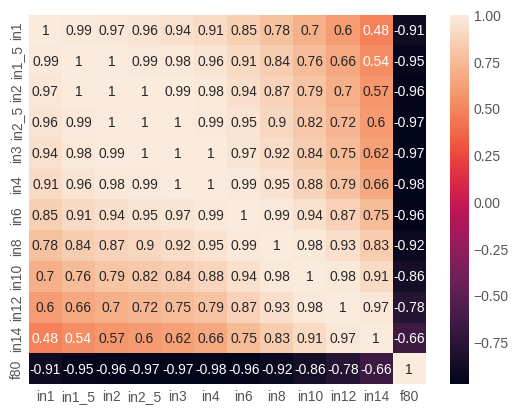

In [110]:
# correlacion entre granulometrias
vars_ = ['in1', 'in1_5', 'in2', 'in2_5', 'in3', 'in4', 'in6', 'in8', 'in10', 'in12', 'in14', 'f80']
sns.heatmap(df[vars_].corr(),
            annot = True)

## 

# Transformación datos a intervalo

La frecuencia de datos debe ser 10 segundos, sin embargo es normal que haya perdida de datos, siempre que estos tenga una diferencia pequeña en tiempo se pueden rellenar


## Rellenos de datos faltantes

In [105]:
df.reset_index().date.diff().value_counts()

date
0 days 00:00:10    43192
0 days 00:01:20        1
Name: count, dtype: int64

In [106]:
#los datos con separación de 20 y 30 segundos se llenenan con un ff
df = df.asfreq('10s')
df = df.ffill(limit = 2) #rellenar a lo máximo 30 segundos
df = df.dropna(how = 'all')
df.reset_index().date.diff().value_counts()

date
0 days 00:00:10    43194
0 days 00:01:00        1
Name: count, dtype: int64

## Data set de intervalos 5 minutos, con variable objetivo

In [108]:
df.columns

Index(['velocidad', 'potencia', 'celda_carga', 'pad_1', 'pad_2', 'pad_3',
       'pad_4', 'pad_5', 'pad_6', 'pad_7', 'pad_8', 'rendimiento',
       'flujo_agua', 'ruido', 'giro', 'p80', 'in14', 'in12', 'in10', 'in8',
       'in6', 'in4', 'in3', 'in2_5', 'in2', 'in1_5', 'in1', 'f80', 'dureza',
       'per_solidos', 'wi', 'spi', 'imp_criticos', 'imp_estandares', 'jb',
       'presion', 'cat_potencia'],
      dtype='object')

In [124]:
df_model = pd.DataFrame(columns = ['velocidad', # promedio
                                   'potencia', # de instante
                                  'rendimiento',#promedio
                                 'ruido',  #de instante
                                  'p80', #promedio
                                  'in14', #promedio
                                   'f80', #promedio
                                   'per_solidos', #promedio
                                    'wi', #promedio
                                 'spi', #promedio
                                 'imp_criticos', #promedio
                                 'imp_estandares', #promedio
                                 'presion', # de instante
                                 ],
                          index = pd.to_datetime([]))
df_model

,velocidad,potencia,rendimiento,ruido,p80,in14,f80,per_solidos,wi,spi,imp_criticos,imp_estandares,presion


In [130]:
for date in df.index:
    #falta ignorar los intervalos con datos perdidos
    delta5 = timedelta(minutes = 5)
    ini = date - delta5
    fin = date
    velocidad = df.loc[ini:fin, 'velocidad'].mean()
    potencia = df.loc[fin, 'potencia']
    rendimiento = df.loc[ini:fin, 'rendimiento'].mean()
    ruido = df.loc[fin, 'ruido']
    p80 = df.loc[ini:fin, 'p80'].mean()
    in14 = f80 = df.loc[ini:fin, 'in14'].mean()
    f80 = df.loc[ini:fin, 'f80'].mean()
    per_solidos = df.loc[ini:fin, 'per_solidos'].mean()
    wi = df.loc[ini:fin, 'wi'].mean()
    spi = df.loc[ini:fin, 'spi'].mean()
    imp_criticos = df.loc[ini:fin, 'imp_criticos'].mean()
    imp_estandares = df.loc[ini:fin, 'imp_estandares'].mean()
    presion = df.loc[fin, 'presion']
    df_model.loc[date, :] = (velocidad, potencia, rendimiento, ruido, p80, in14, f80, per_solidos, wi, spi, imp_criticos, imp_estandares, presion)
    

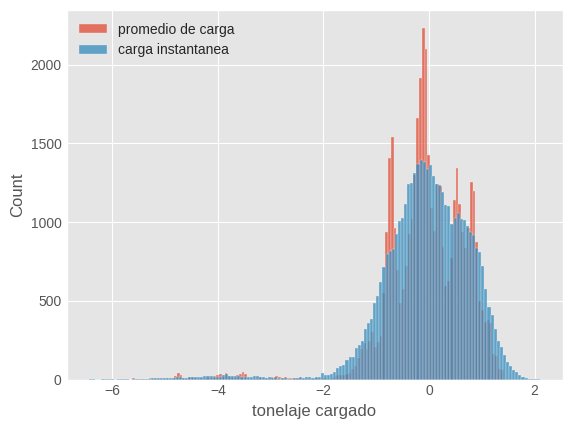

In [136]:
ax = plt.gca()
sns.histplot(df_model.rendimiento,
             label = 'promedio de carga')
sns.histplot(df.rendimiento,
             label = 'carga instantanea')
ax.set_xlabel('tonelaje cargado')
ax.legend()

<Axes: xlabel='rendimiento', ylabel='potencia'>

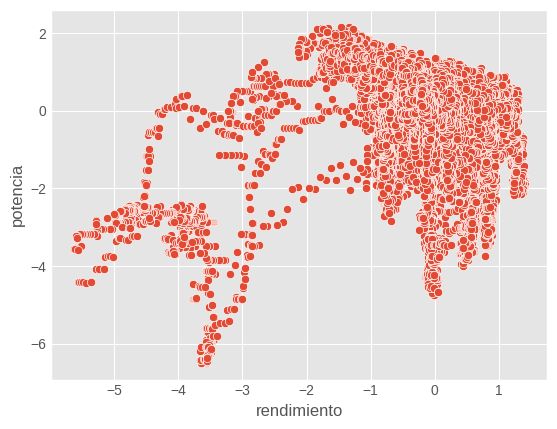

In [147]:
sns.scatterplot(x = 'rendimiento',
                y = 'potencia',
                data = df_model)